In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random, os, pathlib

import torch
import torch.nn as nn
from torch.utils import data

## MNIST dataset

In [2]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn
from classes import *

In [3]:
mnist = datasets.MNIST()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [4]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [5]:
class MNIST_OneClass_Balanced(data.Dataset):
    
    def __init__(self, data, label, class_index):
        self.data = data
        self.label = label
        self.class_index = class_index
        
        mask = (label==class_index)
        self.label = mask.type(torch.float32).reshape(-1,1)
        self.class_data = torch.nonzero(mask).reshape(-1)
        self.other_data = torch.nonzero(~mask).reshape(-1)
        
        self._shuffle_data_()
        self.count = 0
        
    def __len__(self):
        return 2*len(self.class_data)
    
    def _shuffle_data_(self):
        randidx = np.random.permutation(len(self.other_data))
        self.other_data = self.other_data[randidx]
    
    def __getitem__(self, idx):
        if idx < len(self.class_data):
            idx = self.class_data[idx]
            img, lbl = self.data[idx], self.label[idx]
        else:
            idx = self.other_data[idx-len(self.class_data)]
            img, lbl = self.data[idx], self.label[idx]
            self.count += 1
            if self.count >= len(self.class_data): 
                self._shuffle_data_()
                self.count = 0
        return img, lbl

In [36]:
class_idx = 1
train_dataset = MNIST_OneClass_Balanced(train_data, train_label, class_idx)
test_dataset = MNIST_OneClass_Balanced(test_data, test_label, class_idx)

In [7]:
len(train_dataset), len(test_dataset)

(11846, 1960)

tensor([1.])


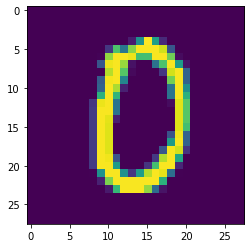

In [8]:
%matplotlib inline
# img, lbl = train_dataset[11010]
img, lbl = test_dataset[10]
print(lbl)
plt.imshow(img.reshape(28,28))

In [9]:
input_size = 784
output_size = 10

learning_rate = 0.0001
batch_size = 50

In [10]:
train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

In [11]:
# network_seeds = [147, 258, 369]
network_seeds = [369]

EPOCHS = 20

actf = nn.LeakyReLU
# actf = nn.ELU

learning_rate = 0.005
lambda_ = 2
criterion = nn.BCELoss()
sigmoid = nn.Sigmoid()

## Logistic Regression

In [12]:
torch.manual_seed(369)
logNet = LogisticRegression(784)
optimizer = torch.optim.Adam(logNet.parameters(), lr=learning_rate)

In [13]:
losses = []
train_accs = []
test_accs = []

index = 0
for epoch in range(20):
    train_acc = 0
    train_count = 0
    for xx, yy in train_loader:
        index += 1

        yout = logNet(xx)    
        loss = criterion(yout, yy)
        losses.append(float(loss))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)

        if index%200 == 0:
            train_accs.append(float(train_acc)/train_count*100)
            train_acc = 0
            train_count = 0

            print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
            test_count = 0
            test_acc = 0
            for xx, yy in test_loader:
                with torch.no_grad():
                    yout = logNet(xx)
                outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
                correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
                test_acc += correct
                test_count += len(xx)
            test_accs.append(float(test_acc)/test_count*100)
            print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
            print("\n")

Epoch: 0:200,  Loss:0.03725191205739975
Train Acc:95.77%, Test Acc:98.57%


Epoch: 1:400,  Loss:0.04085111618041992
Train Acc:98.01%, Test Acc:98.78%


Epoch: 2:600,  Loss:0.01985868252813816
Train Acc:98.22%, Test Acc:98.88%


Epoch: 3:800,  Loss:0.011171667836606503
Train Acc:98.56%, Test Acc:98.67%


Epoch: 4:1000,  Loss:0.06313442438840866
Train Acc:98.54%, Test Acc:98.88%


Epoch: 5:1200,  Loss:0.03121631219983101
Train Acc:98.67%, Test Acc:98.93%


Epoch: 5:1400,  Loss:0.12449567764997482
Train Acc:98.54%, Test Acc:98.78%


Epoch: 6:1600,  Loss:0.006716406438499689
Train Acc:98.62%, Test Acc:98.57%


Epoch: 7:1800,  Loss:0.009142469614744186
Train Acc:98.58%, Test Acc:98.88%


Epoch: 8:2000,  Loss:0.1843794286251068
Train Acc:98.67%, Test Acc:98.52%


Epoch: 9:2200,  Loss:0.07176167517900467
Train Acc:98.84%, Test Acc:98.88%


Epoch: 10:2400,  Loss:0.12318834662437439
Train Acc:98.53%, Test Acc:99.08%


Epoch: 10:2600,  Loss:0.1665513962507248
Train Acc:98.64%, Test Acc:98.93%




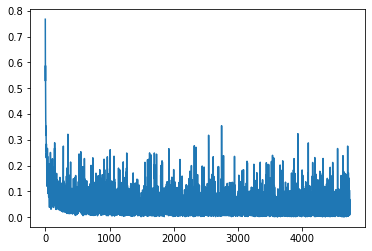

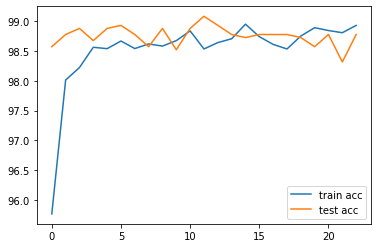

99.08163265306122 at step: 2200


In [14]:
plt.plot(losses)
plt.show()
plt.plot(train_accs, label='train acc')
plt.plot(test_accs, label='test acc')
plt.legend()
plt.show()
print(max(test_accs), 'at step:', np.argmax(test_accs)*200)

## Convex

In [37]:
torch.manual_seed(369)
cvxNet = ConvexNN([784,200,100,1], actf)
optimizer = torch.optim.Adam(cvxNet.parameters(), lr=learning_rate)

In [38]:
losses = []
train_accs = []
test_accs = []

index = 0
for epoch in range(20):
    train_acc = 0
    train_count = 0
    for xx, yy in train_loader:
        index += 1

        yout = sigmoid(cvxNet(xx))    
        loss = criterion(yout, yy)
        losses.append(float(loss))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)

        if index%200 == 0:
            train_accs.append(float(train_acc)/train_count*100)
            train_acc = 0
            train_count = 0

            print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
            test_count = 0
            test_acc = 0
            for xx, yy in test_loader:
                with torch.no_grad():
                    yout = cvxNet(xx)
                outputs = (yout.data.cpu().numpy() > 0).astype(float)
                correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
                test_acc += correct
                test_count += len(xx)
            test_accs.append(float(test_acc)/test_count*100)
            print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
            print("\n")

Epoch: 0:200,  Loss:0.12804493308067322
Train Acc:92.90%, Test Acc:99.08%


Epoch: 1:400,  Loss:0.08297356963157654
Train Acc:98.25%, Test Acc:99.13%


Epoch: 2:600,  Loss:0.019687289372086525
Train Acc:98.73%, Test Acc:98.93%




KeyboardInterrupt: 

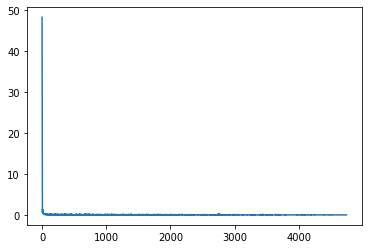

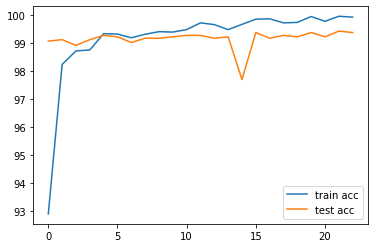

99.43877551020408 at step: 4200


In [23]:
plt.plot(losses)
plt.show()
plt.plot(train_accs, label='train acc')
plt.plot(test_accs, label='test acc')
plt.legend()
plt.show()
print(max(test_accs), 'at step:', np.argmax(test_accs)*200)

## NN

In [24]:
torch.manual_seed(369)
mlpNet = nn.Sequential(nn.Linear(784, 200),
                       actf(),
                       nn.Linear(200,100),
                       actf(),
                       nn.Linear(100,1))
optimizer = torch.optim.Adam(mlpNet.parameters(), lr=learning_rate)

In [25]:
losses = []
train_accs = []
test_accs = []

index = 0
for epoch in range(20):
    train_acc = 0
    train_count = 0
    for xx, yy in train_loader:
        index += 1

        yout = sigmoid(mlpNet(xx))    
        loss = criterion(yout, yy)
        losses.append(float(loss))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)

        if index%200 == 0:
            train_accs.append(float(train_acc)/train_count*100)
            train_acc = 0
            train_count = 0

            print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
            test_count = 0
            test_acc = 0
            for xx, yy in test_loader:
                with torch.no_grad():
                    yout = mlpNet(xx)
                outputs = (yout.data.cpu().numpy() > 0).astype(float)
                correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
                test_acc += correct
                test_count += len(xx)
            test_accs.append(float(test_acc)/test_count*100)
            print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
            print("\n")

Epoch: 0:200,  Loss:0.00772550143301487
Train Acc:97.20%, Test Acc:98.93%


Epoch: 1:400,  Loss:0.0008176472038030624
Train Acc:98.91%, Test Acc:99.44%


Epoch: 2:600,  Loss:0.00018880375137086958
Train Acc:99.40%, Test Acc:99.29%


Epoch: 3:800,  Loss:0.0007474260055460036
Train Acc:99.48%, Test Acc:98.93%


Epoch: 4:1000,  Loss:0.0005391020094975829
Train Acc:99.81%, Test Acc:99.44%


Epoch: 5:1200,  Loss:5.919463001191616e-05
Train Acc:99.73%, Test Acc:99.13%


Epoch: 5:1400,  Loss:0.0006220584618858993
Train Acc:99.62%, Test Acc:99.34%


Epoch: 6:1600,  Loss:0.0016614423366263509
Train Acc:99.78%, Test Acc:99.44%


Epoch: 7:1800,  Loss:1.8434093362884596e-05
Train Acc:99.77%, Test Acc:99.39%


Epoch: 8:2000,  Loss:0.000271571334451437
Train Acc:99.75%, Test Acc:99.03%


Epoch: 9:2200,  Loss:0.00022052139684092253
Train Acc:100.00%, Test Acc:99.34%


Epoch: 10:2400,  Loss:0.0001376785949105397
Train Acc:99.87%, Test Acc:99.34%


Epoch: 10:2600,  Loss:0.025564787909388542
Train Acc:9

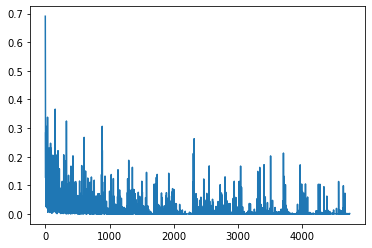

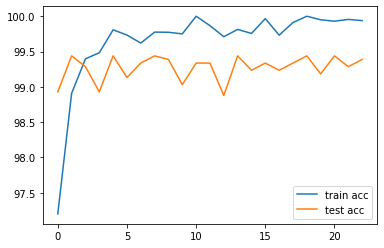

99.43877551020408 at step: 200


In [26]:
plt.plot(losses)
plt.show()
plt.plot(train_accs, label='train acc')
plt.plot(test_accs, label='test acc')
plt.legend()
plt.show()
print(max(test_accs), 'at step:', np.argmax(test_accs)*200)

# QuasiConvex

In [32]:
torch.manual_seed(369)
lips_net = nn.Sequential(nn.Linear(784, 200),
                       actf(),
                       nn.Linear(200,100),
                       actf(),
                       nn.Linear(100,1))
lcNet = BasicInvexNet(784, lips_net, lamda=lambda_)
optimizer = torch.optim.Adam(lcNet.parameters(), lr=learning_rate)

In [33]:
losses = []
train_accs = []
test_accs = []

index = 0
for epoch in range(20):
    train_acc = 0
    train_count = 0
    for xx, yy in train_loader:
        index += 1

        yout = sigmoid(lcNet(xx)) 
        lcNet.compute_penalty_and_clipper()
        loss = criterion(yout, yy) + lcNet.gp
        losses.append(float(loss))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)

        if index%200 == 0:
            train_accs.append(float(train_acc)/train_count*100)
            train_acc = 0
            train_count = 0
            
            min_val, gp = float(lcNet.cond.min()) , float(lcNet.gp)
            print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}, MinVal:{min_val}, gp: {gp}')
            test_count = 0
            test_acc = 0
            for xx, yy in test_loader:
#                 with torch.no_grad():
                yout = lcNet(xx)
                outputs = (yout.data.cpu().numpy() > 0).astype(float)
                correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
                test_acc += correct
                test_count += len(xx)
            test_accs.append(float(test_acc)/test_count*100)
            print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
            print("\n")

Epoch: 0:200,  Loss:0.00966580118983984, MinVal:1.6776198148727417, gp: 4.911155212424755e-31
Train Acc:95.15%, Test Acc:98.67%


Epoch: 1:400,  Loss:0.0007149972952902317, MinVal:1.601951003074646, gp: 1.0420810458344688e-29
Train Acc:98.92%, Test Acc:99.29%


Epoch: 2:600,  Loss:9.932788816513494e-05, MinVal:0.3326866626739502, gp: 1.1235900387873698e-07
Train Acc:99.17%, Test Acc:99.08%


Epoch: 3:800,  Loss:0.0015857876278460026, MinVal:6.8420515060424805, gp: 0.0
Train Acc:99.39%, Test Acc:99.29%


Epoch: 4:1000,  Loss:0.015332337468862534, MinVal:4.298842906951904, gp: 0.0
Train Acc:99.46%, Test Acc:99.23%


Epoch: 5:1200,  Loss:0.00017315727018285543, MinVal:1.6076335906982422, gp: 8.065513240765931e-30
Train Acc:99.87%, Test Acc:99.18%


Epoch: 5:1400,  Loss:0.0005992838996462524, MinVal:1.9391298294067383, gp: 1.405893969949748e-35
Train Acc:99.78%, Test Acc:99.34%


Epoch: 6:1600,  Loss:0.0017741912743076682, MinVal:4.970850467681885, gp: 0.0
Train Acc:99.74%, Test Acc:99.18%

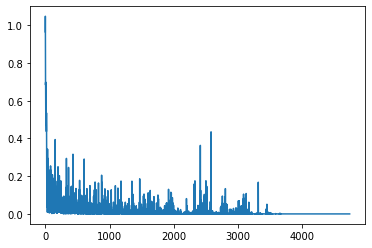

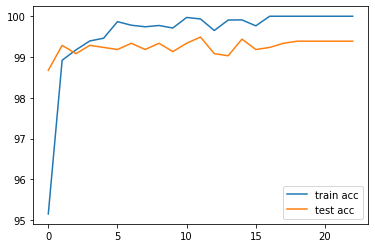

99.48979591836735 at step: 2200


In [34]:
plt.plot(losses)
plt.show()
plt.plot(train_accs, label='train acc')
plt.plot(test_accs, label='test acc')
plt.legend()
plt.show()
print(max(test_accs), 'at step:', np.argmax(test_accs)*200)

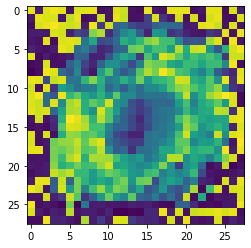

In [35]:
plt.imshow(lcNet.center.data.numpy().reshape(28,28))